### Portfolio 3: MEG acquisition, analysis and report

*By Sofie Mosegaard*

## Preprocessing of IQT MEG data

In [1]:
import os
path = '/work/SofieNørboMosegaard#5741/AdvCogNeuro'
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [2]:
import os
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import mne
from mne import concatenate_raws, io
from mne.preprocessing import maxwell_filter

import glob

# Import packages for ML
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from collections import Counter
import imblearn
from imblearn.under_sampling import RandomUnderSampler

plt.ion() 

### Load data

In [ ]:
# single-level analysis on subject 0145

data_path = "/work/MEG_data"
subject_id = "0145"
date_stamp = "20240925_000000"

# Paths to session A and session B for subject 0145
sessA_path = os.path.join(data_path, subject_id, date_stamp, "MEG", "001.sessA", "files")
sessB_path = os.path.join(data_path, subject_id, date_stamp, "MEG", "002.sessB", "files")

# File names for the two sessions
sessA_file = os.path.join(sessA_path, "sessA.fif")
sessB_file = os.path.join(sessB_path, "sessB.fif")

# Initialize empty list to store the data from both sessions
sessions_data = []

# Load the two sessions and apply Maxwell filtering to align head positions 

if os.path.isfile(sessA_file):
    raw_A = io.read_raw_fif(sessA_file, preload=True)
    raw_A = maxwell_filter(raw_A, origin='auto', coord_frame='head')
    sessions_data.append(raw_A)
else:
    print(f"SessA file not found: {sessA_file}")

if os.path.isfile(sessB_file):
    raw_B = io.read_raw_fif(sessB_file, preload=True)
    raw_B = maxwell_filter(raw_B, origin='auto', coord_frame='head')
    sessions_data.append(raw_B)
else:
    print(f"SessB file not found: {sessB_file}")

# Set 'dev_head_t' to match across sessions
reference_dev_head_t = sessions_data[0].info['dev_head_t'] # Use dev_head_t from sessA as the common transformation
sessions_data[1].info['dev_head_t'] = reference_dev_head_t # # Apply reference dev_head_t to the sessB to align dev_head_t 

# Concatenate the sessions
raw = concatenate_raws(sessions_data)

# Save
output_filename = '/work/SofieNørboMosegaard#5741/AdvCogNeuro/notebooks_MEG/sub0145_sessAB_merged.fif'
#raw.save(output_filename, overwrite = True)

# load the data, if already saved
#raw = mne.io.read_raw_fif(output_filename, preload = True)

In [4]:
# Check the duration and number of samples
print(f"Data duration: {raw.times[-1]} seconds")   # 1453.999 seconds = 24,2 min.
print(f"Number of samples: {len(raw.times)}")      # 1,454,000

Data duration: 1453.999 seconds
Number of samples: 1454000


### Inspect raw data

In [5]:
raw.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG002, ECG003, IASX+, IASX-, IASY+, IASY-, IASZ+, ...
 chs: 2 EOG, 1 ECG, 11 Internal Active Shielding data (Triux systems), 102 Magnetometers, 204 Gradiometers, 1 misc, 1 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 description: TRIUX system at Aarhus-3103
 dev_head_t: MEG device -> head transform
 dig: 182 items (3 Cardinal, 4 HPI, 175 Extra)
 events: 1 item (list)
 experimenter: Andreas Hojlund (hojlund)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2024-09-25 08:45:54 UTC
 meas_id: 4 items (dict)
 nchan: 323
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: cogsci_teaching
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 6 items (dict)
>

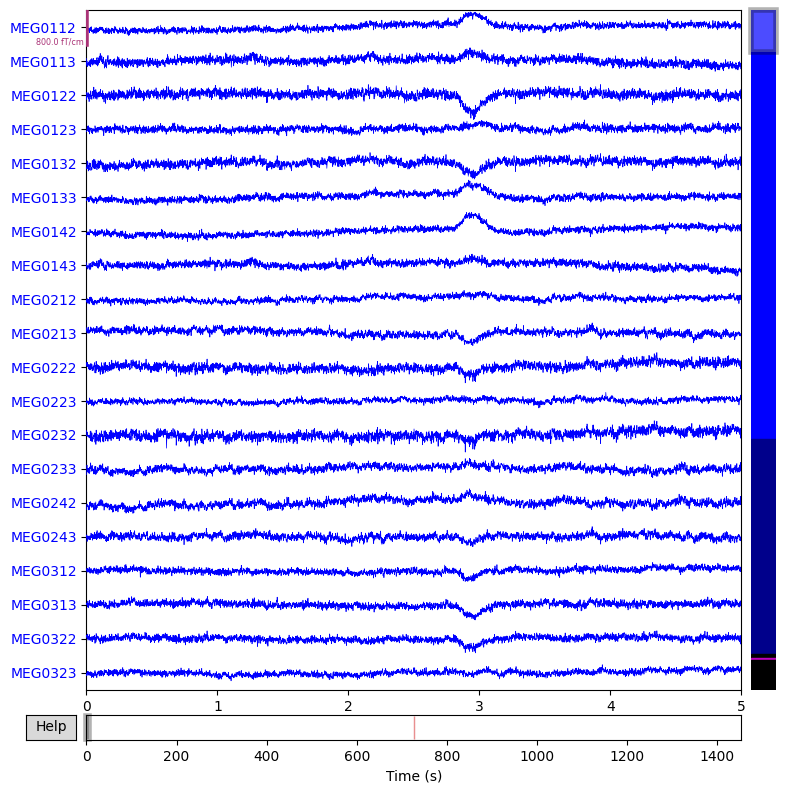

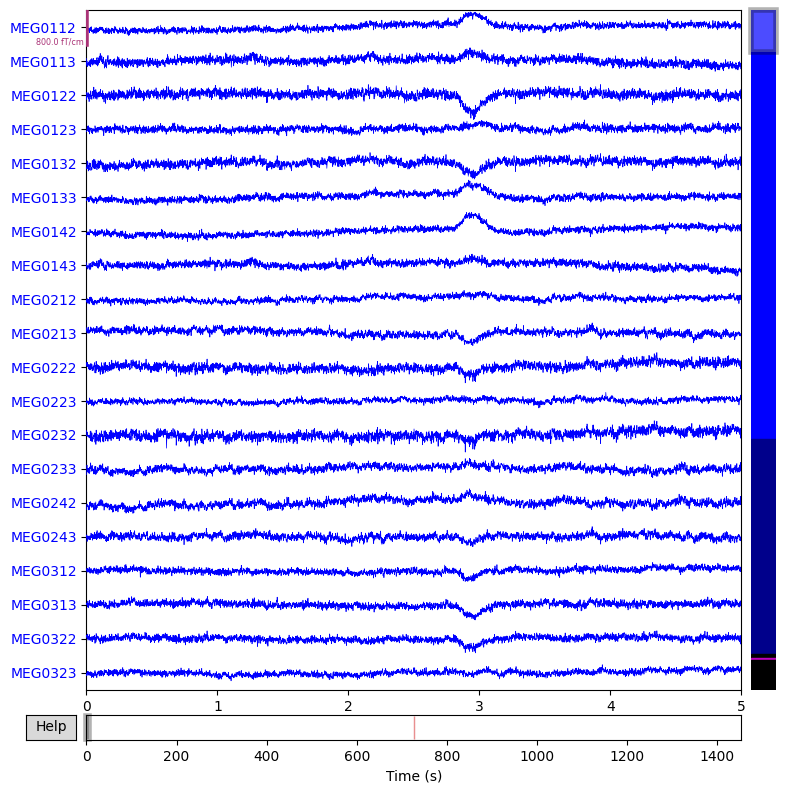

In [8]:
raw.plot(start = 0, duration = 5)

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


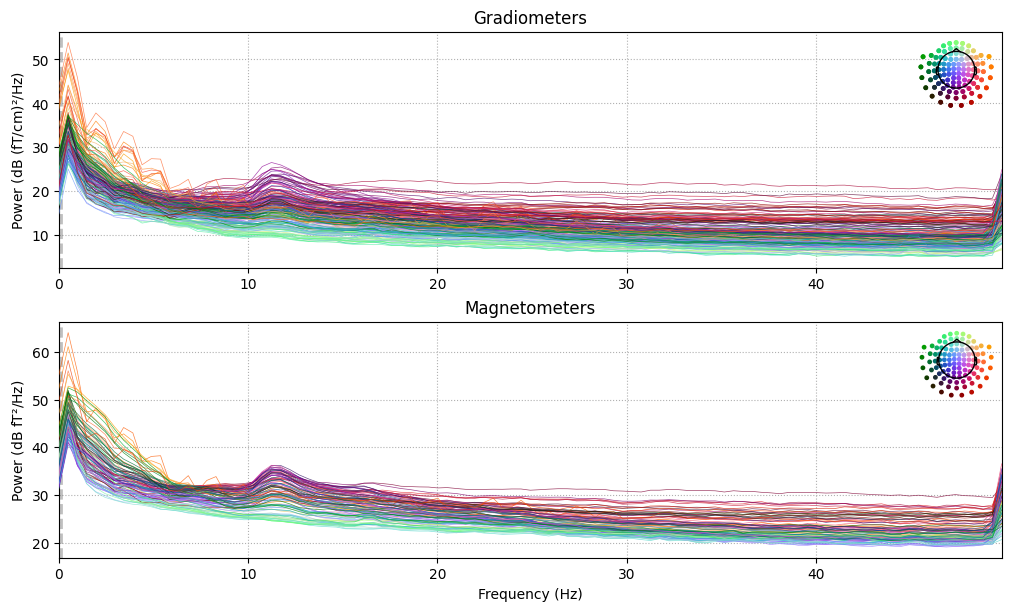

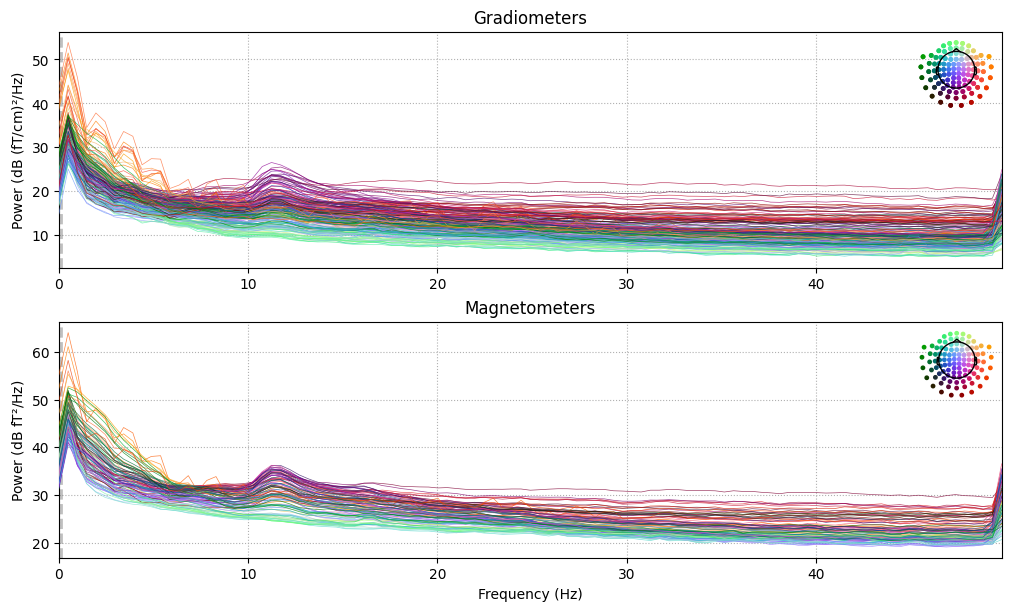

In [25]:
raw.compute_psd(fmax = 50).plot(picks = "data")

Effective window size : 2.048 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.9s finished


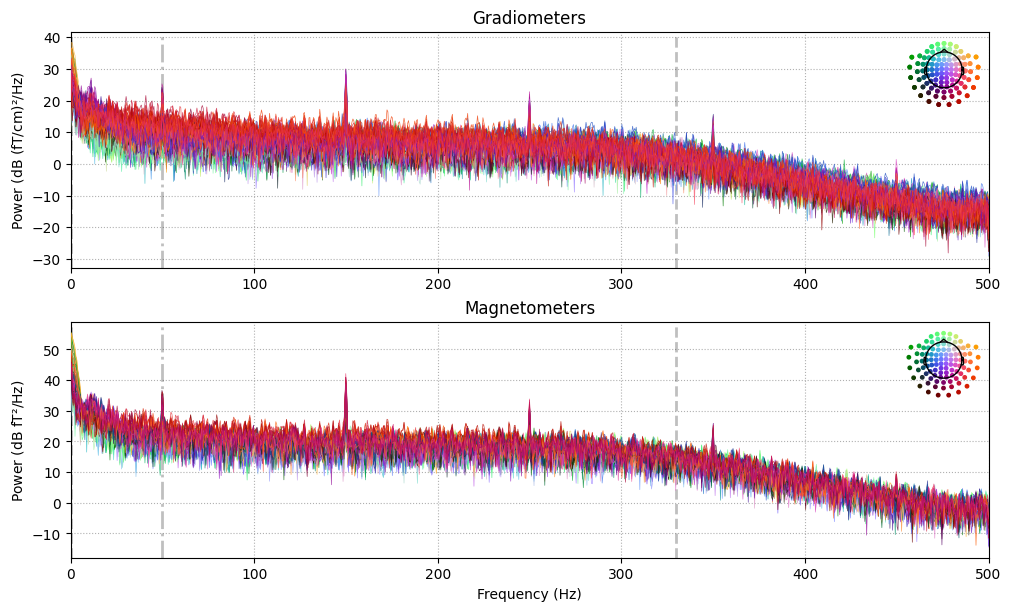

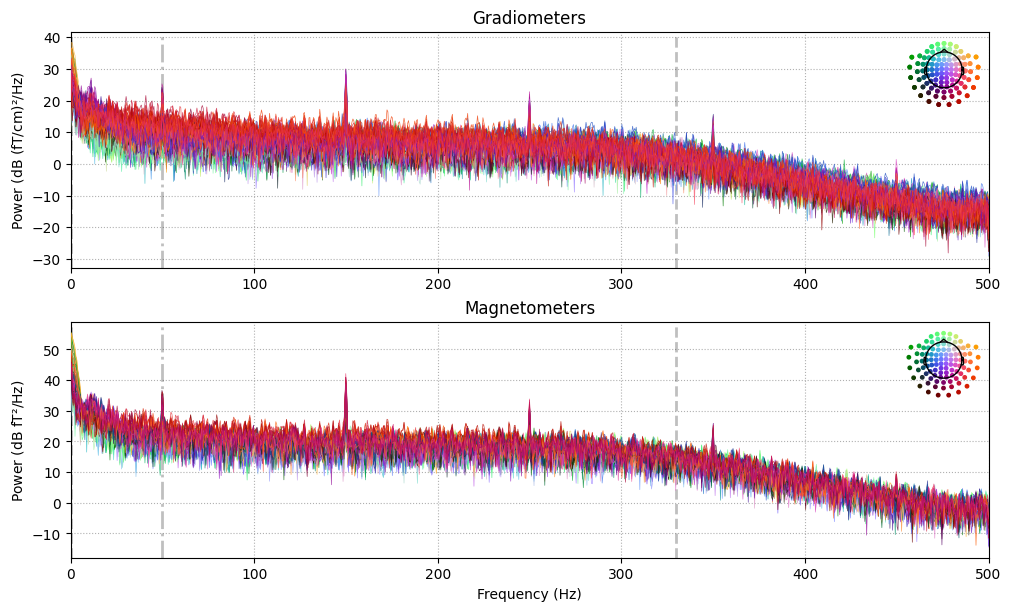

In [26]:
raw.compute_psd(n_jobs = -1, tmax = 9).plot()

Using matplotlib as 2D backend.


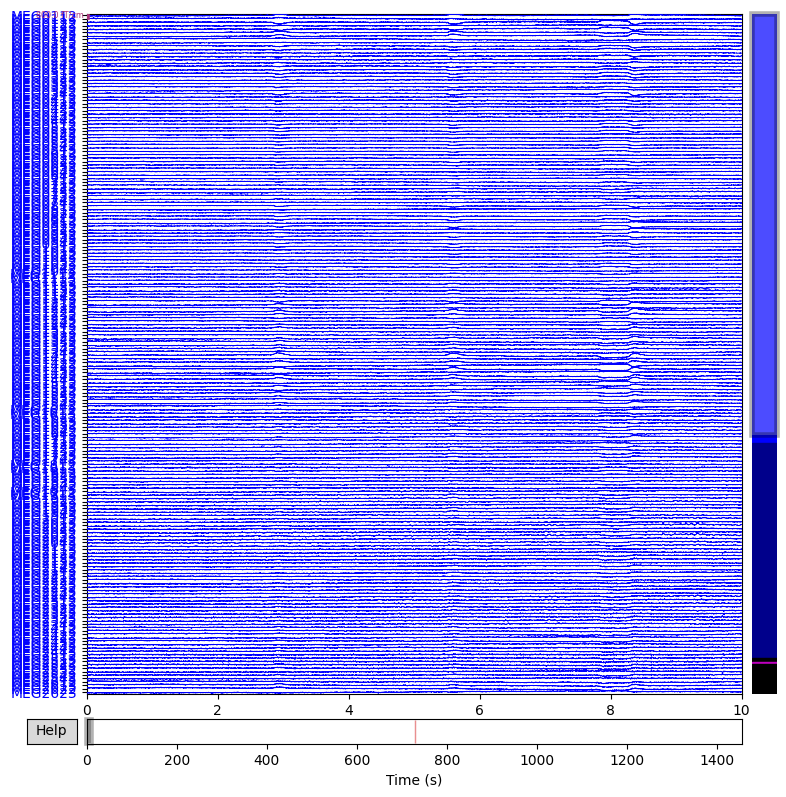

In [4]:
raw.plot(n_channels = 200);

We can see some bad channels and some drift in some of the signal. Now, I'll add some filtering to see, if that can help.

### Filtering

Lowpass filter of 40 Hz (meaning, all frequencies lower than the threshold will pass through and higher frequencies will be removed --> including removal of muscle artefacts and noise from power cords).

Highpass filter is already set to 0.1 Hz (removing low frequencies and minimises slow drifts, for example scalp potentials). This will not be lowered.

In [4]:
low_pass = 40 
filtered_raw = raw.filter(None, low_pass)

Filtering raw data in 2 contiguous segments
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    7.1s


In [4]:
filtered_raw.info # check to see the changes

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG002, ECG003, IASX+, IASX-, IASY+, IASY-, IASZ+, ...
 chs: 2 EOG, 1 ECG, 11 Internal Active Shielding data (Triux systems), 102 Magnetometers, 204 Gradiometers, 1 misc, 1 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 description: TRIUX system at Aarhus-3103
 dev_head_t: MEG device -> head transform
 dig: 182 items (3 Cardinal, 4 HPI, 175 Extra)
 events: 1 item (list)
 experimenter: Andreas Hojlund (hojlund)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 2024-09-25 08:45:54 UTC
 meas_id: 4 items (dict)
 nchan: 323
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: cogsci_teaching
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 6 items (dict)
>

### Power spectral density plots

Here I plot frequencies below 50 Hz, as the data are low-pass filtered at 40 Hz.

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


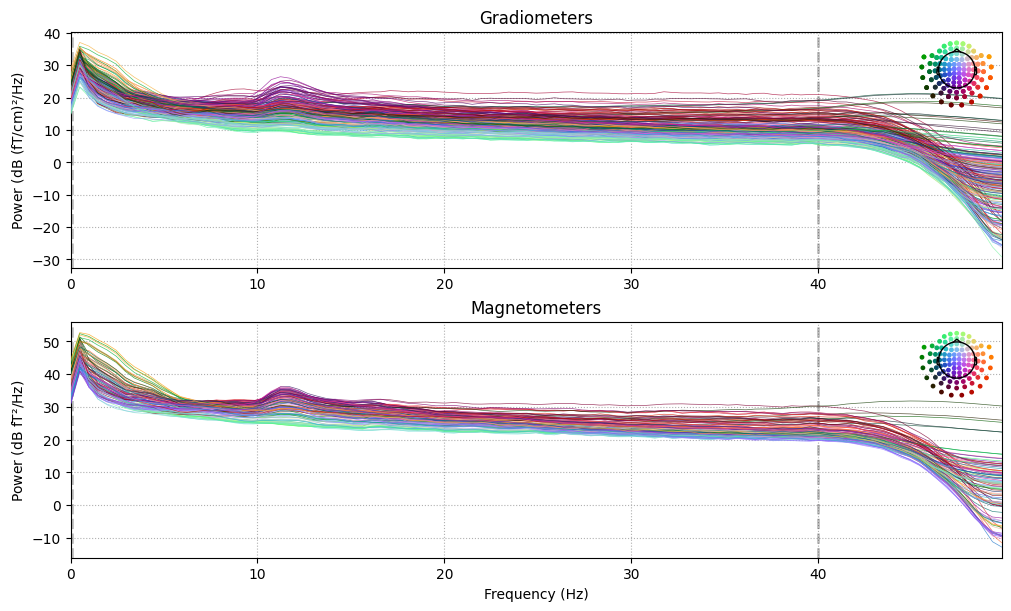

In [18]:
filtered_raw.compute_psd(fmax = 50).plot(picks = "data", exclude = "bads");

### Artefact removal with Independent Component Analysis (ICA)

The data will be cleaned using ICA, which is a computational method for separating a multivariate signal into additive subcomponents. These subcomponents will often represent artifacts (eye blinks, heart beat, signal drift, etc.), which we natrually want to remove.

In [5]:
# set up and fit the ICA to the MEG data
ica = mne.preprocessing.ICA(n_components = 10, random_state = 123, max_iter = 800)
ica.fit(filtered_raw)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 103.7s.


<ICA | raw data decomposition, method: fastica (fit in 32 iterations on 1454000 samples), 10 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
727 matching events found
No baseline correction applied
0 projection items activated


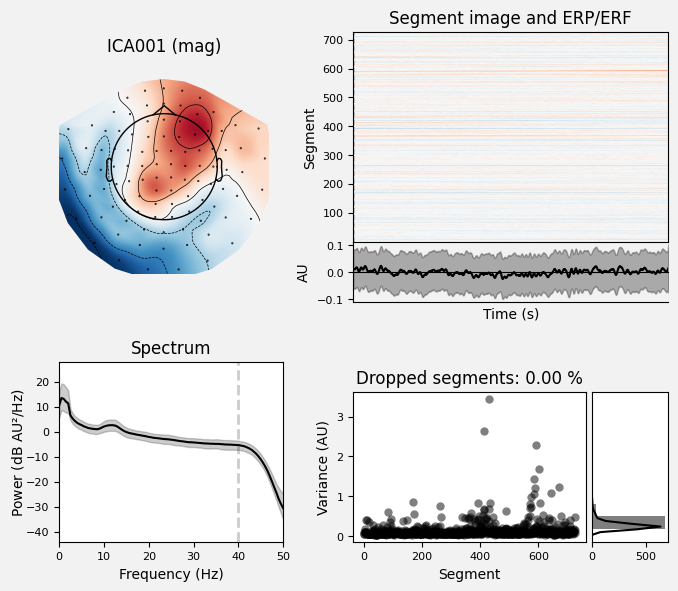

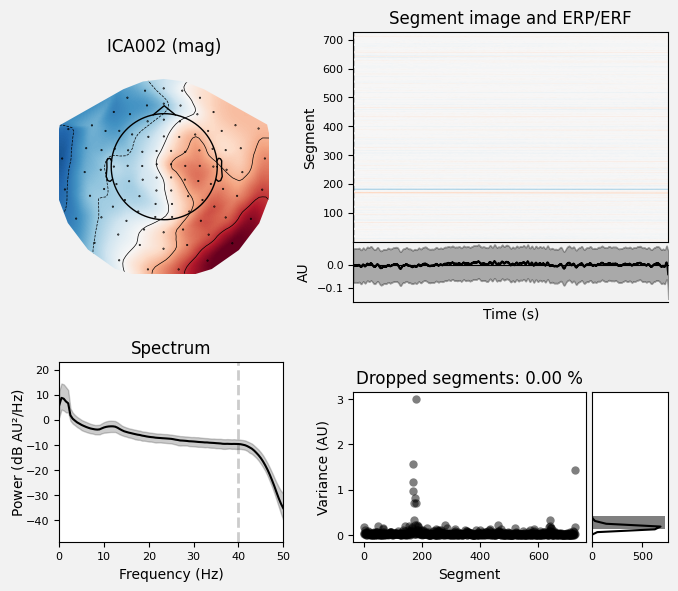

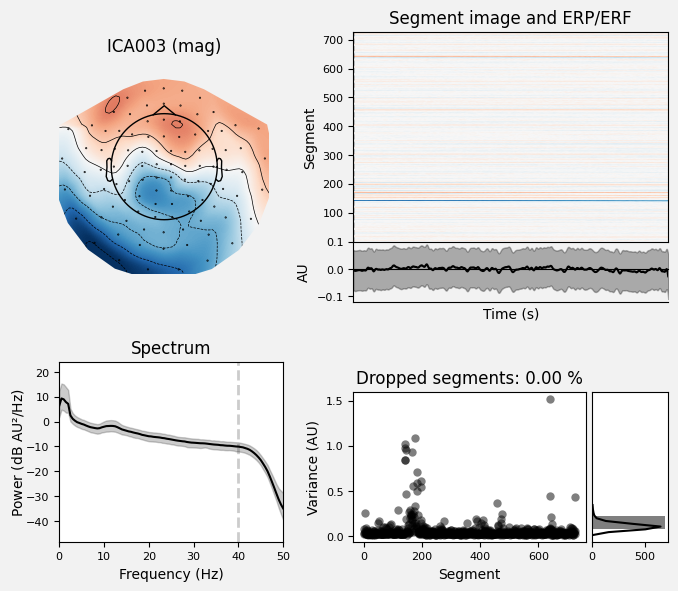

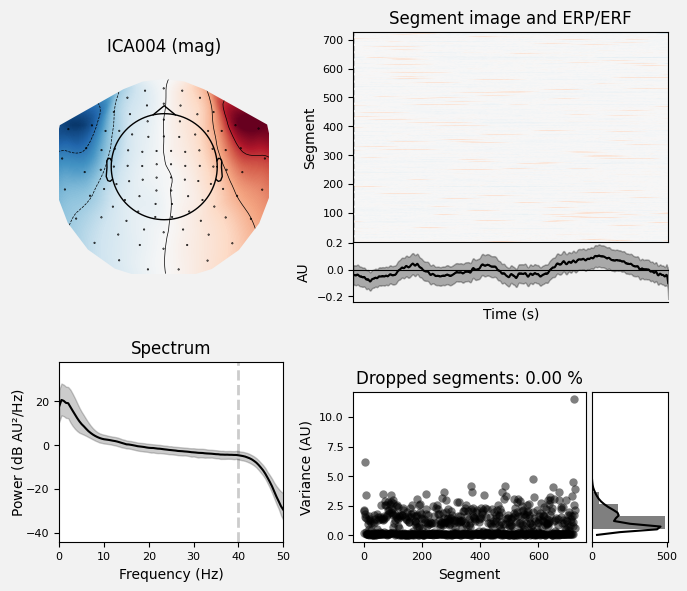

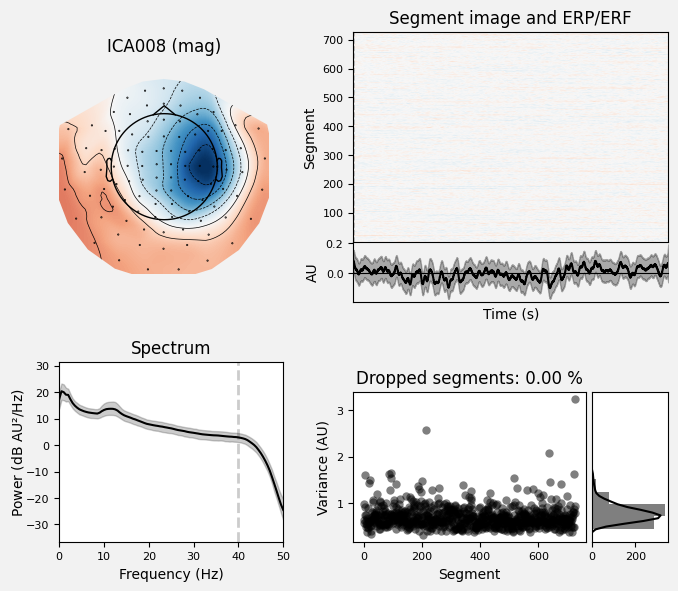

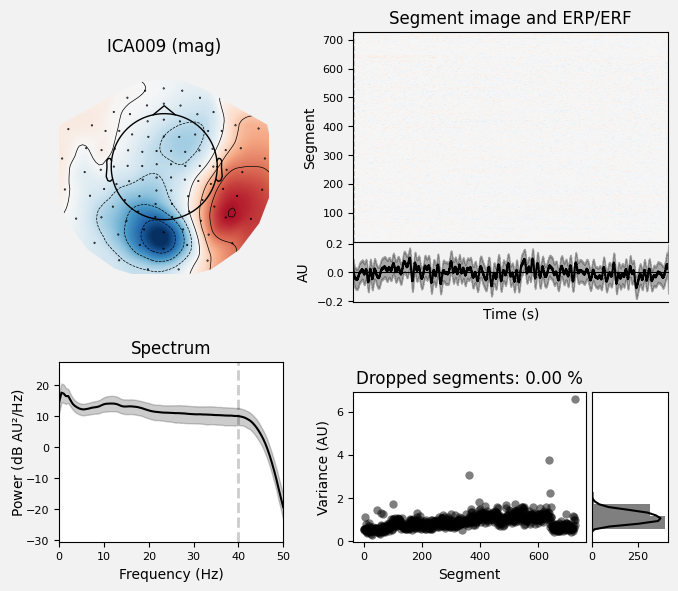

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [6]:
ica.exclude = [1, 2, 3, 4, 8, 9]
ica.plot_properties(filtered_raw, picks = ica.exclude)

The components will now be passed as the 'exclude' parameter and applied to the raw signal:

In [8]:
# find channel names
# print(filtered_raw.ch_names)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 6 ICA components
    Projecting back using 306 PCA components
before ICA - on specific channels
Using matplotlib as 2D backend.


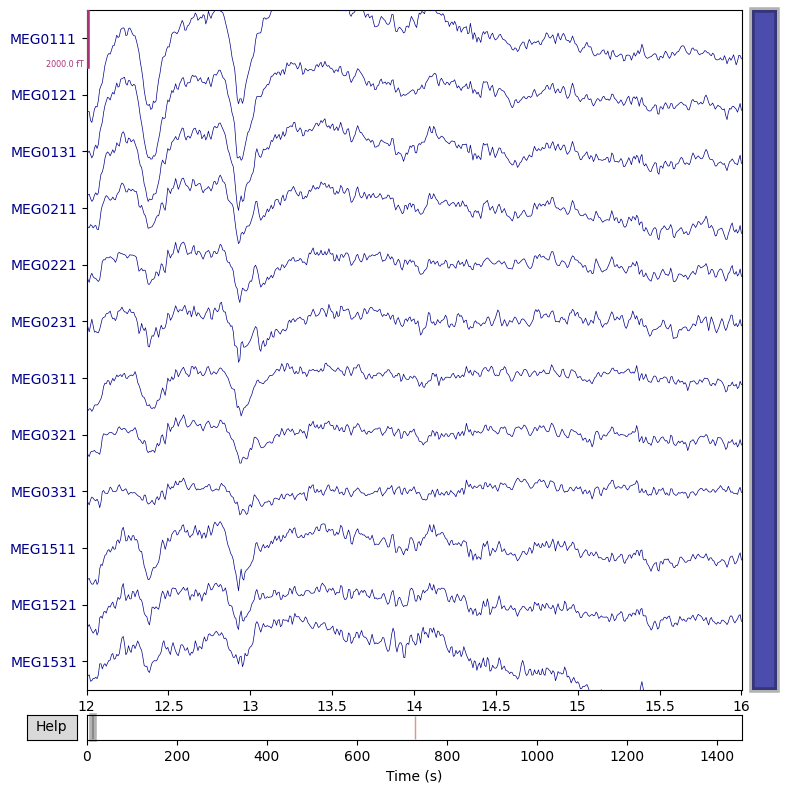

after ICA - on specific channels


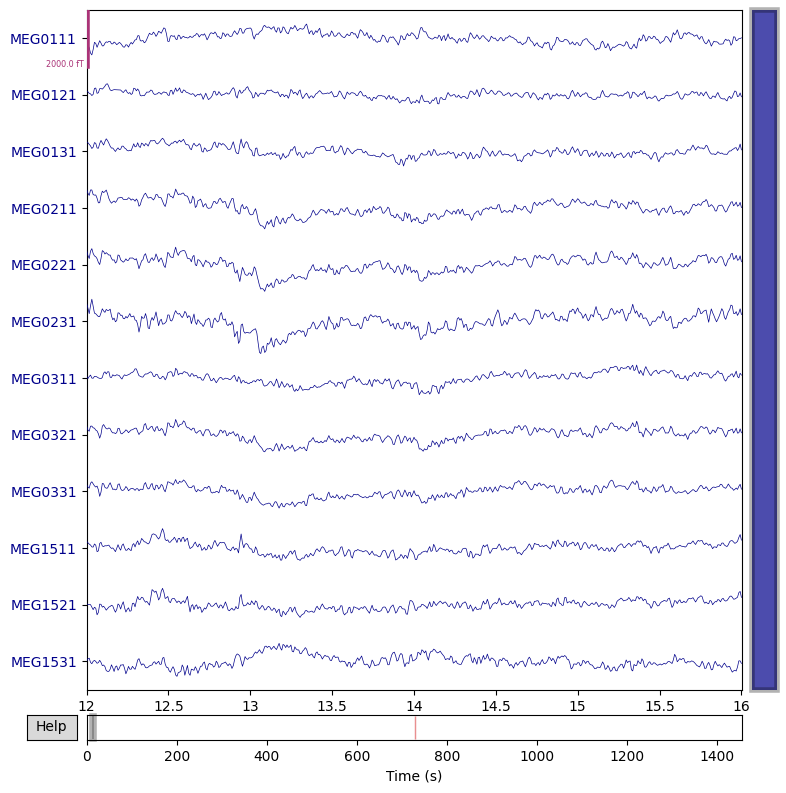

before ICA - on all channels


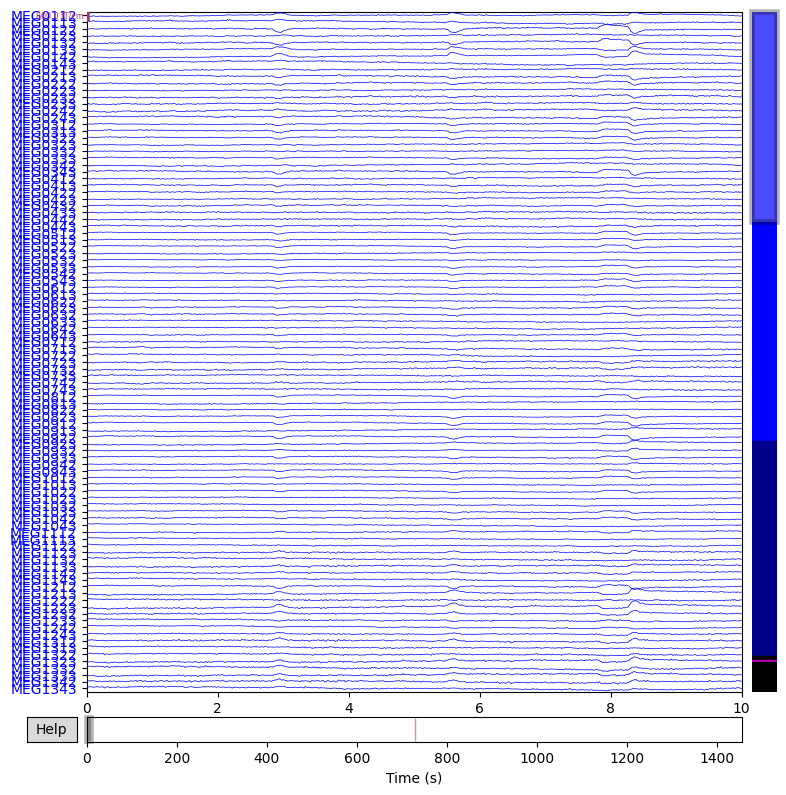

after ICA - on all channels


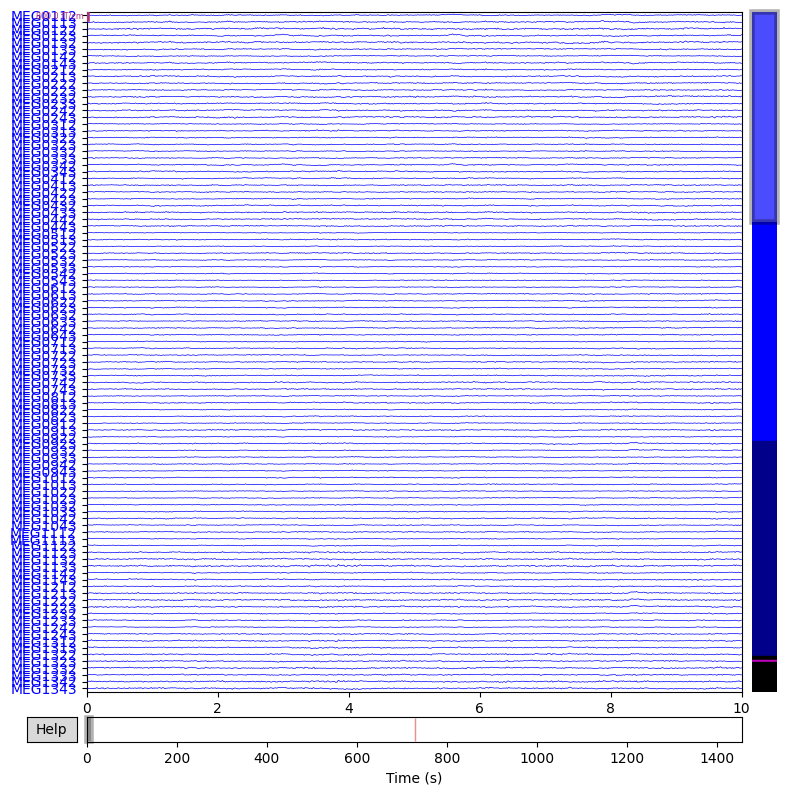

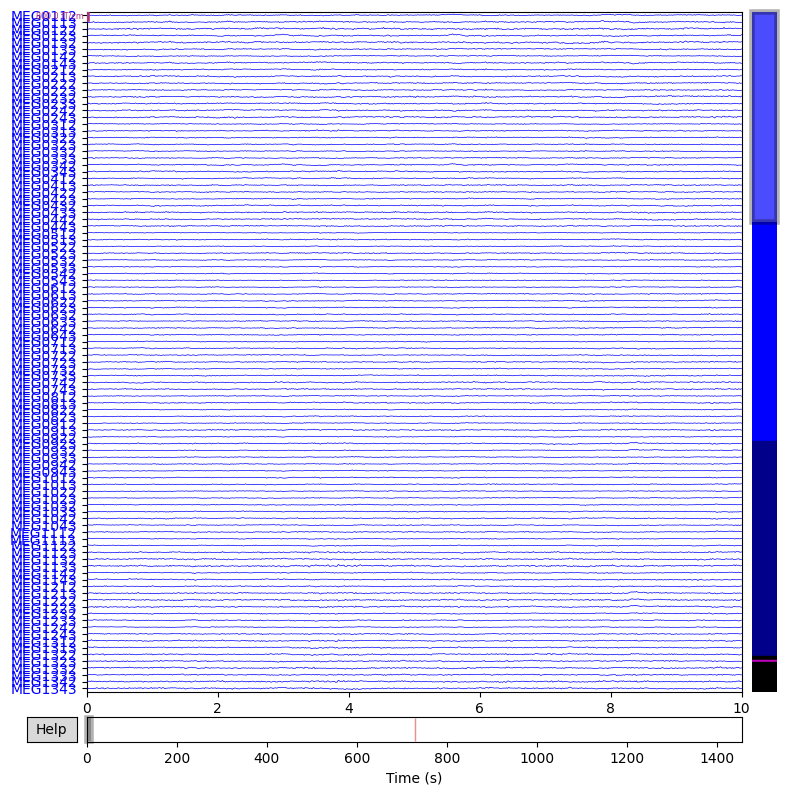

In [7]:
orig_raw = filtered_raw.copy()
filtered_raw.load_data()
preprocessed_data = ica.apply(filtered_raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG0111', 'MEG0121', 'MEG0131', 'MEG0211', 'MEG0221', 'MEG0231',
       'MEG0311', 'MEG0321', 'MEG0331', 'MEG1511', 'MEG1521', 'MEG1531']

chan_idxs = [preprocessed_data.ch_names.index(ch) for ch in chs]

# Print results

print("before ICA - on specific channels")
orig_raw.plot(order = chan_idxs, start = 12, duration = 4)

print("after ICA - on specific channels")
preprocessed_data.plot(order = chan_idxs, start = 12, duration = 4)

print("before ICA - on all channels")
orig_raw.plot(n_channels = 100)

print("after ICA - on all channels")
preprocessed_data.plot(n_channels = 100)

All the channels look great! :)

### Event detection

In [8]:
events = mne.find_events(preprocessed_data, min_duration = 0.002, consecutive = True)  # returns a numpy array

3997 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16 110 120 126 130 134 140 156 210
 211 220 221 230 231 238 239 240 241 243 246 247 252 254 255]


/tmp/ipykernel_7213/1929120688.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq = raw.info["sfreq"]);


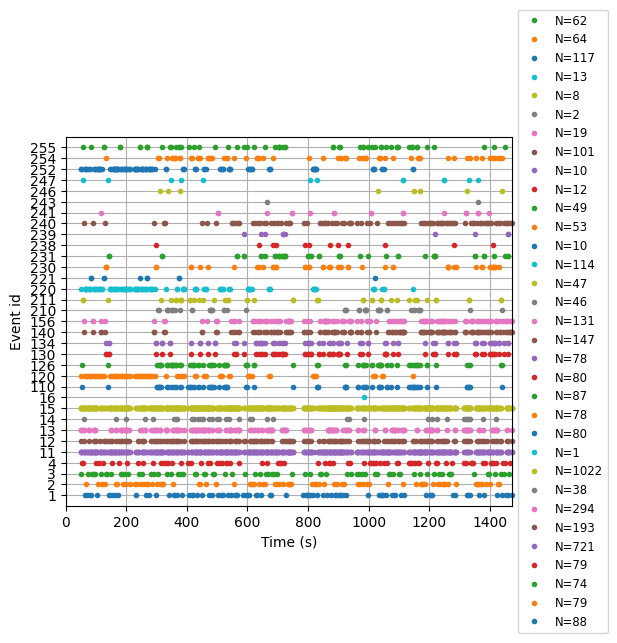

In [9]:
mne.viz.plot_events(events, sfreq = raw.info["sfreq"]);

In [10]:
# Defining the triggers/events 

event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
              }   

### Segment data into epochs

#### + set rejection criteria (to drop noice once again)

Rejecting MEG epochs with signal above 4000 femtotesla:

In [11]:
reject_criteria = dict(mag = 4000e-15,     # 4000 fT
                       grad = 4000e-13,    # 4000 fT/cm
                       eog = 250e-6        # 250 µV
                       )       

epochs = mne.Epochs(preprocessed_data,
                    events,
                    event_id,
                    tmin = -0.2,
                    tmax = 0.5,
                    reject = reject_criteria,
                    preload = True)

Not setting metadata
1144 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1144 events and 701 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rej

    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting

In [11]:
epochs

<Epochs | 1067 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~1.80 GB, data loaded,
 'Visual/Deck/One': 86
 'Visual/Deck/Two': 79
 'Visual/Deck/Three': 74
 'Visual/Deck/Four': 77
 'Visual/Win/One': 43
 'Visual/Win/Two': 86
 'Visual/Win/Three': 51
 'Visual/Win/Four': 82
 'Visual/Loss/One': 47
 'Visual/Loss/Two': 8
 and 6 more events ...>

### Epoching continuous data

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


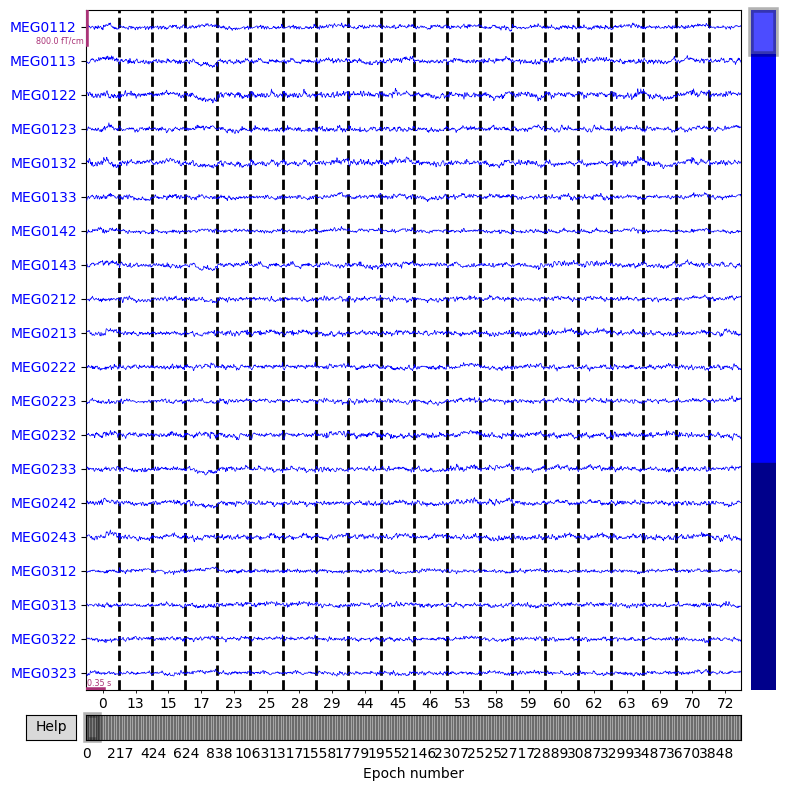

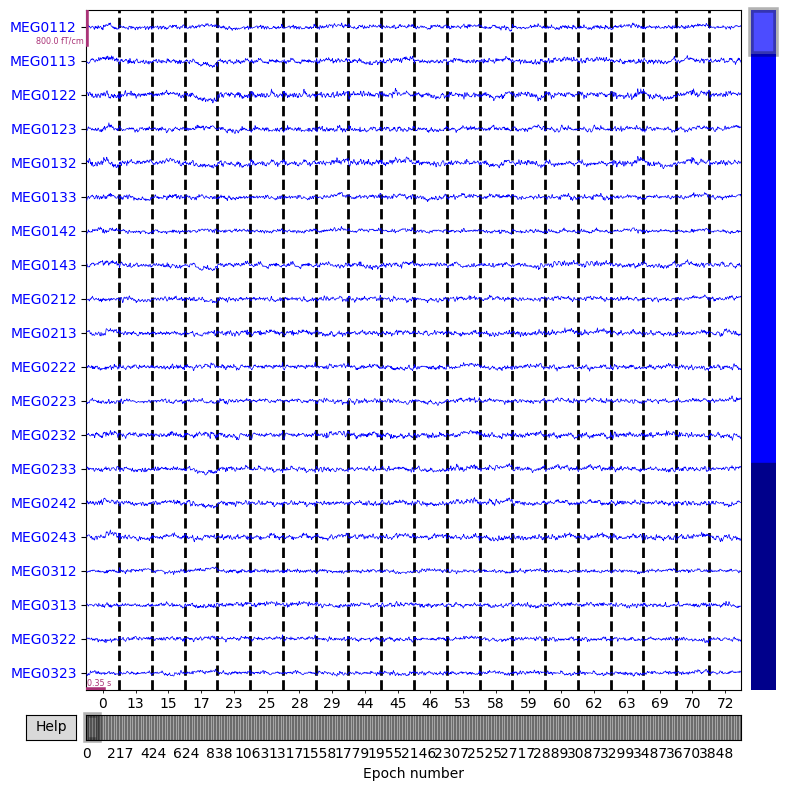

In [16]:
# Visualise the epochs (only MEG channels)

epochs.pick_types(meg = True, eog = False, ias = False, emg = False, misc = False, stim = False, syst = False)
epochs.plot()

All the channels look great! :)

### Inspect win/loss epochs

In [12]:
conds_to_look_into = ['Visual/Win/One', 'Visual/Win/Two', 'Visual/Win/Three', 'Visual/Win/Four',
                        'Visual/Loss/One', 'Visual/Loss/Two', 'Visual/Loss/Three', 'Visual/Loss/Four']

Now, I want to pool across all decks to compare all win and loss responses.

In [13]:
win_epochs = epochs['Win']
loss_epochs = epochs['Loss']

del raw, epochs  # free up memory

In [14]:
print(win_epochs)
print(loss_epochs)

<Epochs | 262 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~457.7 MB, data loaded,
 'Visual/Win/One': 43
 'Visual/Win/Two': 86
 'Visual/Win/Three': 51
 'Visual/Win/Four': 82>
<Epochs | 123 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~217.6 MB, data loaded,
 'Visual/Loss/One': 47
 'Visual/Loss/Two': 8
 'Visual/Loss/Three': 49
 'Visual/Loss/Four': 19>


Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated


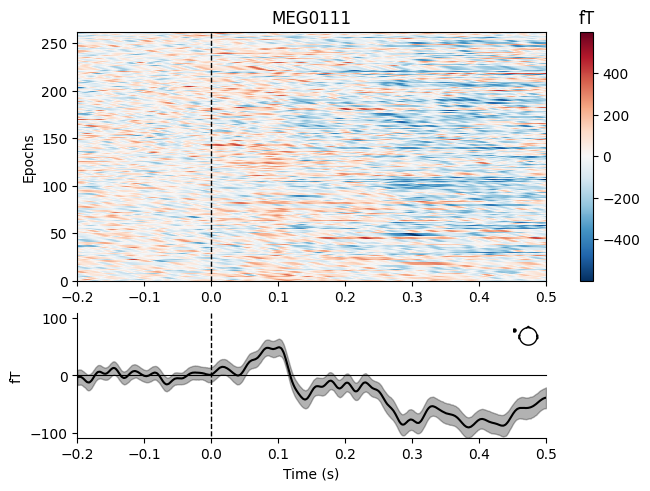

[<Figure size 640x480 with 4 Axes>]

In [17]:
win_epochs.plot_image(picks = 'MEG0111')

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


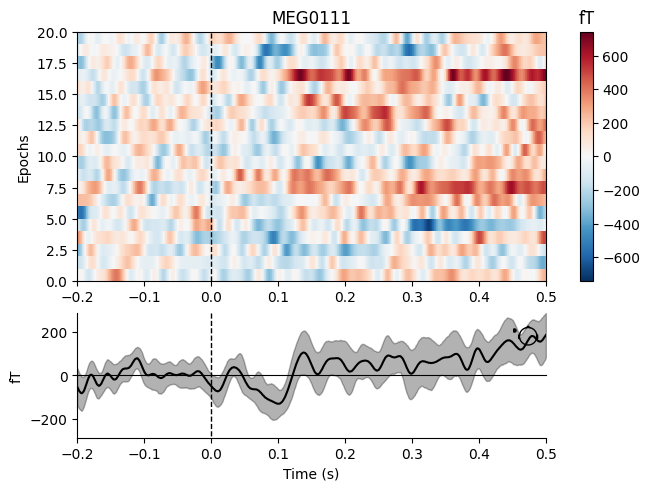

[<Figure size 640x480 with 4 Axes>]

In [112]:
loss_epochs.plot_image(picks = 'MEG0111')

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.1s


No baseline correction applied


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.9s


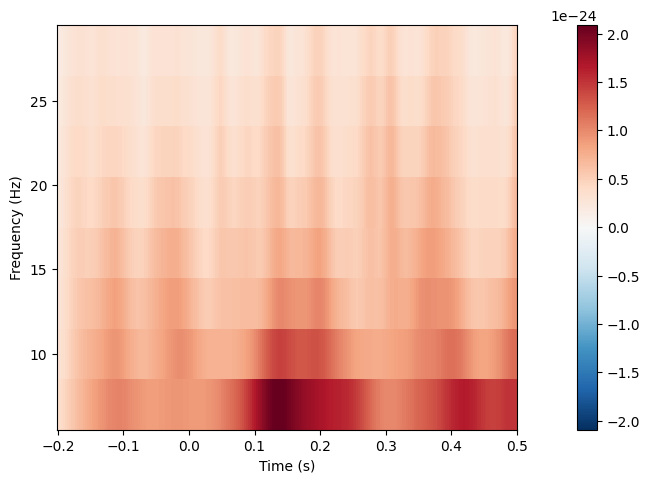

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.8s


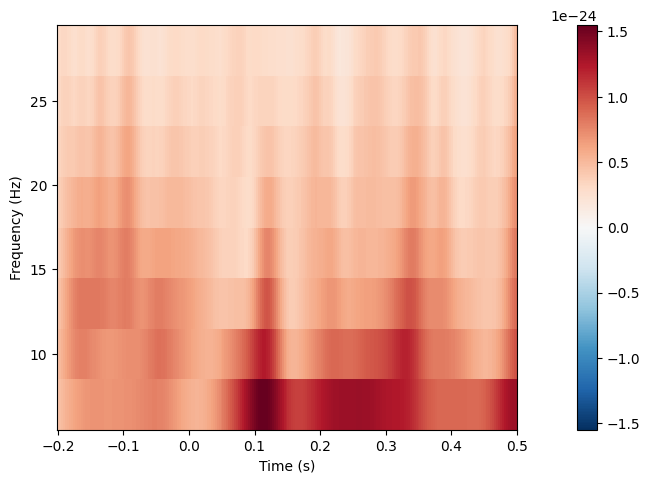

[<Figure size 640x480 with 2 Axes>]

In [113]:
# Time-frequency analysis

frequencies = np.arange(7, 30, 3)

win_power = win_epochs.compute_tfr("morlet", n_cycles = 2, return_itc = False, freqs = frequencies, decim = 3, average = True)
win_power.plot(['MEG0111'])

loss_power = loss_epochs.compute_tfr("morlet", n_cycles = 2, return_itc = False, freqs = frequencies, decim = 3, average = True)
loss_power.plot(['MEG0111'])

### Estimating averaged evoked responses
Now, to get an estimate of the evoked response to the "win" and "loss" stimuli, I can average the epochs together in each condition:

In [15]:
win_evoked = win_epochs.average()
loss_evoked = loss_epochs.average()

In [21]:
print(win_evoked)
print(loss_evoked)

<Evoked | '0.16 × Visual/Win/One + 0.33 × Visual/Win/Two + 0.19 × Visual/Win/Three + 0.31 × Visual/Win/Four' (average, N=262), -0.2 – 0.5 s, baseline -0.2 – 0 s, 306 ch, ~6.7 MB>
<Evoked | '0.38 × Visual/Loss/One + 0.07 × Visual/Loss/Two + 0.40 × Visual/Loss/Three + 0.15 × Visual/Loss/Four' (average, N=123), -0.2 – 0.5 s, baseline -0.2 – 0 s, 306 ch, ~6.7 MB>


Multiple channel types selected, returning one figure per type.
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


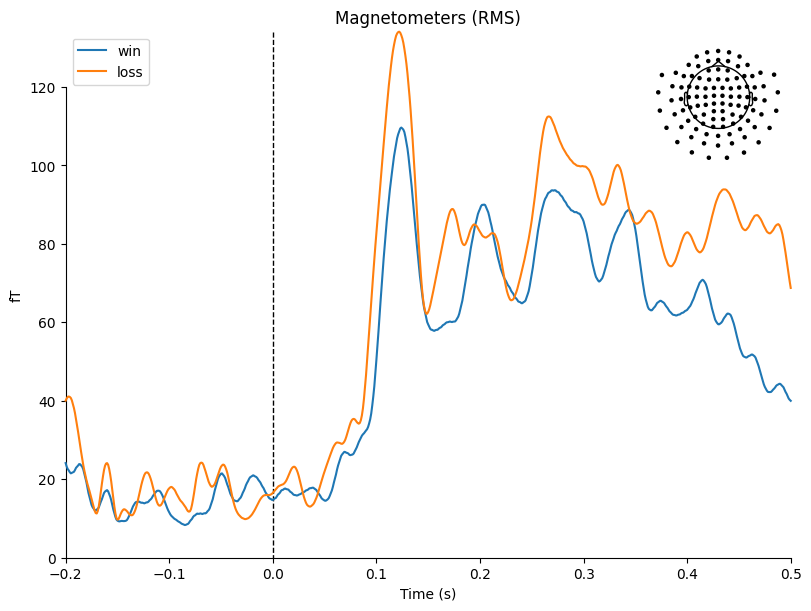

combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


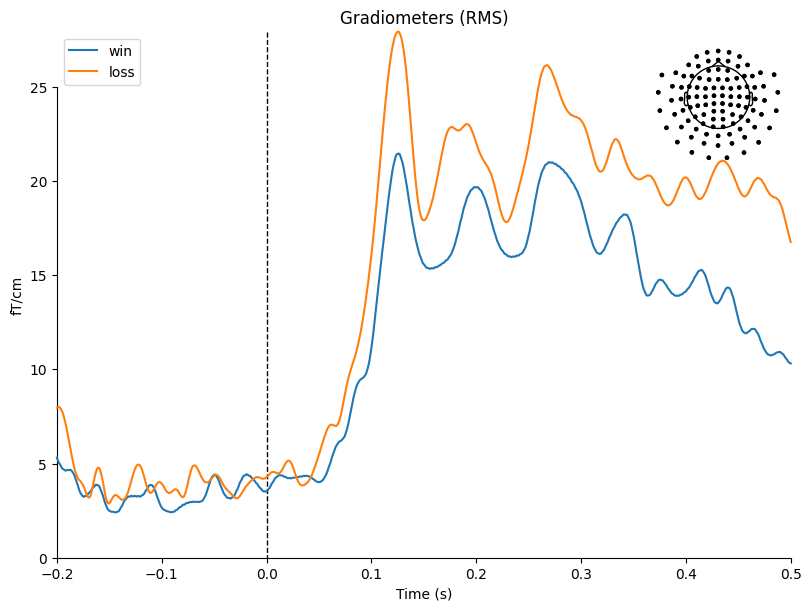

[<Figure size 800x600 with 2 Axes>, <Figure size 800x600 with 2 Axes>]

In [22]:
mne.viz.plot_compare_evokeds(dict(win = win_evoked, loss = loss_evoked),
                             legend = 'upper left',
                             show_sensors = 'upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


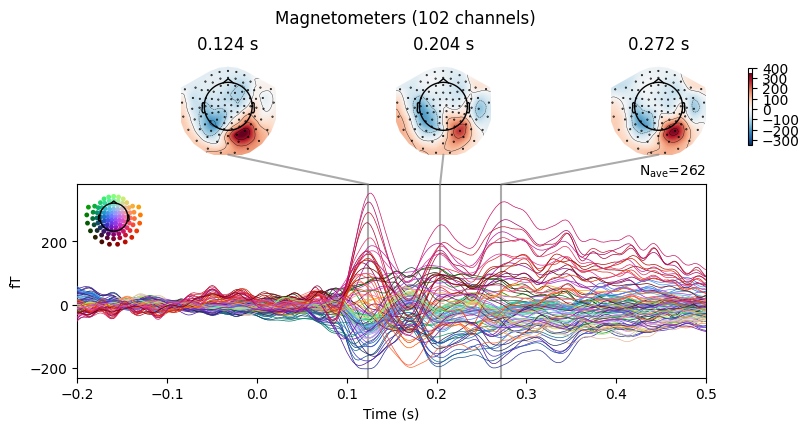

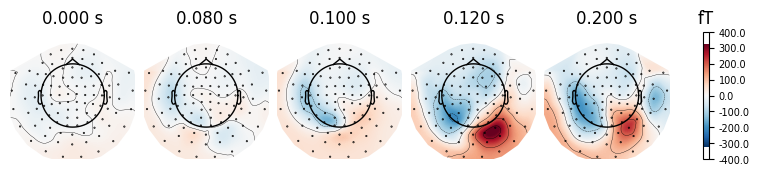

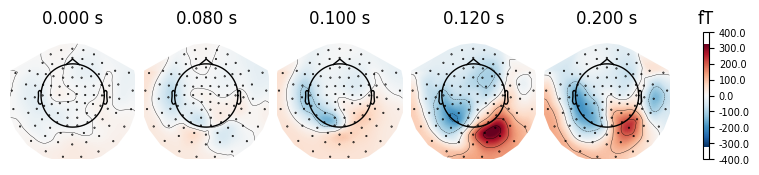

In [23]:
win_evoked.plot_joint(picks = 'mag')
win_evoked.plot_topomap(times = [0., 0.08, 0.1, 0.12, 0.2], ch_type = 'mag')

No projector specified for this dataset. Please consider the method self.add_proj.


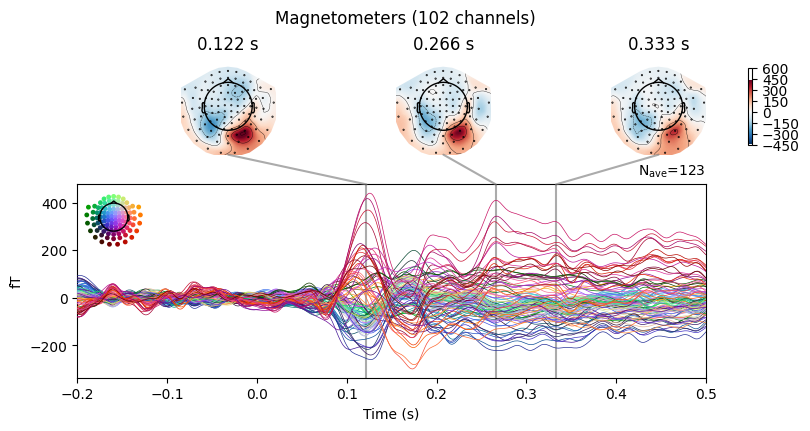

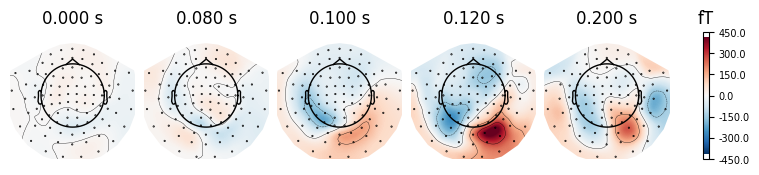

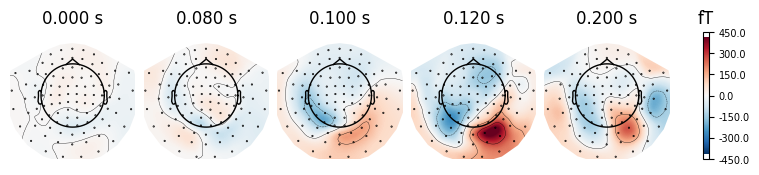

In [24]:
loss_evoked.plot_joint(picks = 'mag')
loss_evoked.plot_topomap(times = [0., 0.08, 0.1, 0.12, 0.2], ch_type = 'mag')

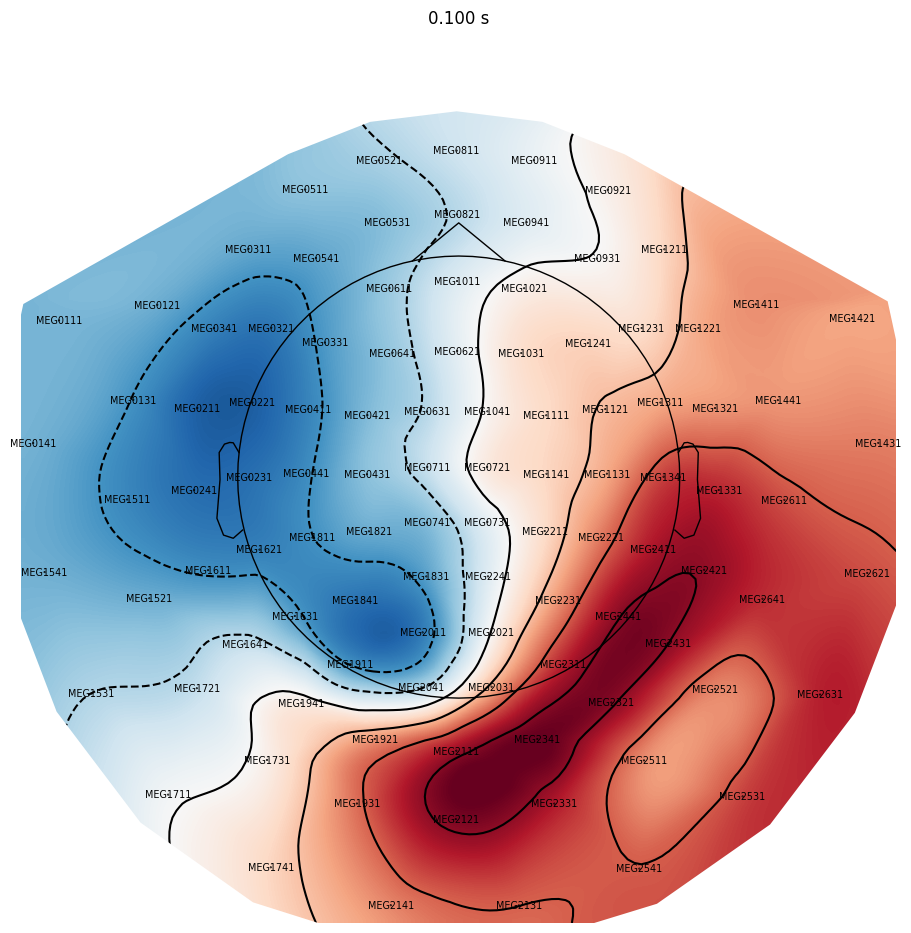

<Figure size 640x480 with 0 Axes>

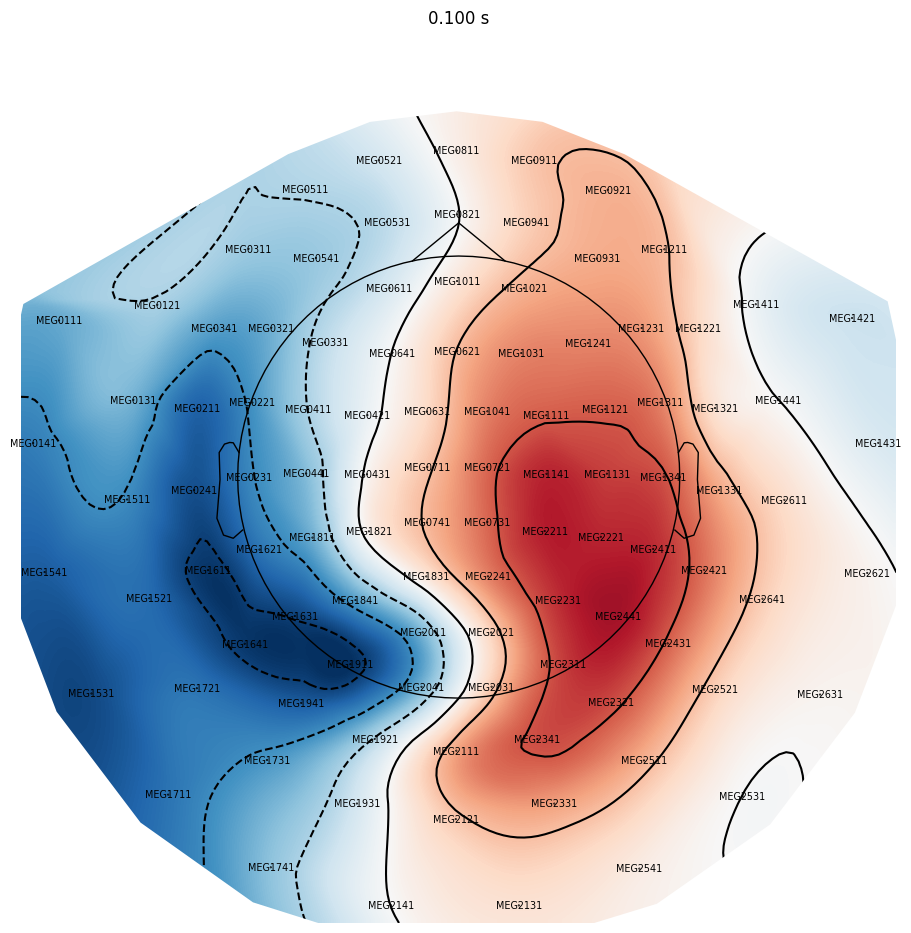

<Figure size 640x480 with 0 Axes>

In [123]:
win_evoked.plot_topomap(0.1, ch_type = 'mag', show_names = True, colorbar = False,
                    size = 6, res = 128, time_unit = 's')
plt.subplots_adjust(left = 0.01, right = 0.99, bottom = 0.01, top = 0.88)

loss_evoked.plot_topomap(0.1, ch_type = 'mag', show_names = True, colorbar = False,
                    size = 6, res = 128, time_unit = 's')
plt.subplots_adjust(left = 0.01, right = 0.99, bottom = 0.01, top = 0.88)

### Classification/Decoding analysis

In [15]:
win_data = win_epochs.get_data()
loss_data = loss_epochs.get_data()

print(f"Win data shape: {win_data.shape}")   # (262, 323, 701)
print(f"Loss data shape: {loss_data.shape}") # (123, 323, 701)

# (n_win_epochs, n_channels, n_times)

Win data shape: (262, 323, 701)
Loss data shape: (123, 323, 701)


In [16]:
# Concatenate win and loss data along the first dimension (epochs)
X = np.concatenate([win_data, loss_data], axis = 0)

print(f"X shape: {X.shape}") # (385, 323, 701)

# (n_total_epochs, n_channels, n_times)

X shape: (385, 323, 701)


In [17]:
# Flatten X to 2D 
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)

print(f"X shape: {X.shape}") # (385, 226423)

X shape: (385, 226423)


In [18]:
# Create labels (1 for win, 0 for loss)
y = np.concatenate([np.ones(len(win_data)), np.zeros(len(loss_data))])

print(f"y shape: {y.shape}") # (385,)
Counter(y) # {1.0: 262, 0.0: 123}

y shape: (385,)


Counter({1.0: 262, 0.0: 123})

In [19]:
# UnderSample to balance the classes

undersample = RandomUnderSampler(random_state = 123)
X_undersampled, y_undersampled = undersample.fit_resample(X, y)
Counter(y_undersampled) # Counter({0.0: 123, 1.0: 123})

Counter({0.0: 123, 1.0: 123})

In [20]:
# Split the data randomly into training and test split with 80/20 split

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size = 0.2, random_state = 123)

print(f"X_train shape: {X_train.shape}") # (196, 226423)
print(f"y_train shape: {y_train.shape}") # (196,)

print(f"X_test shape: {X_test.shape}") # (50, 226423)
print(f"y_test shape: {y_test.shape}") # (50,)

X_train shape: (196, 226423)
y_train shape: (196,)
X_test shape: (50, 226423)
y_test shape: (50,)


### ML

In [22]:
classifier_svm = make_pipeline(StandardScaler(), svm.SVC())

In [23]:
classifier_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [24]:
y_pred = classifier_svm.predict(X_test)

In [25]:
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91        29
         1.0       0.83      0.95      0.89        21

    accuracy                           0.90        50
   macro avg       0.90      0.91      0.90        50
weighted avg       0.91      0.90      0.90        50



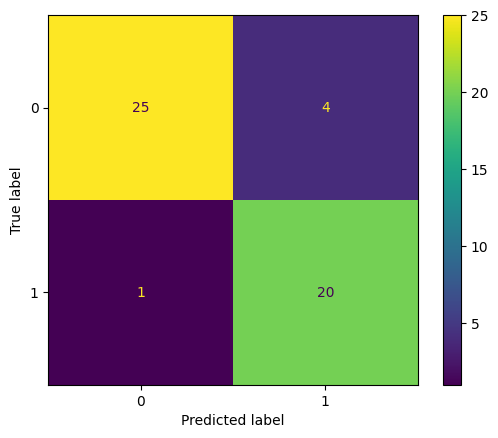

In [31]:
# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
disp.plot(cmap = "viridis")

In [ ]:
# Perform 5-fold cross-validation
scores = cross_val_score(classifier_svm, X, y, cv = 5, scoring = 'accuracy')

# Print the accuracy scores for each fold
print(f"Cross-validation scores: {scores}")

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean CV accuracy: {round(np.mean(scores),4)}")
print(f"Standard deviation of CV accuracy: {round(np.std(scores),4)}")